In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import awkward1 as ak

from coffea import processor, hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

import numpy as np


In [100]:
from Tools.objects import *
from Tools.basic_objects import *
from Tools.cutflow import *
from Tools.config_helpers import *
from Tools.triggers import *
from Tools.btag_scalefactors import *
from Tools.lepton_scalefactors import *

year = 2018

lumis = {2016: 36., 2017: 41.5, 2018: 60.}

btagSF = btag_scalefactor(year)

leptonSF = LeptonSF(year=year)

#processes = []


In [101]:
class forwardJetAnalyzer(processor.ProcessorABC):
    def __init__(self):
                # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        phi_axis            = hist.Bin("phi",       r"$\phi$", 60, -3.2, 3.2)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        ext_multiplicity_axis   = hist.Bin("multiplicity",         r"N", 100, -0.5, 99.5) # e.g. for PV
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "PV_npvs" :          hist.Hist("PV_npvs", dataset_axis, ext_multiplicity_axis),
            "PV_npvsGood" :      hist.Hist("PV_npvsGood", dataset_axis, ext_multiplicity_axis),
            
            "MET" :              hist.Hist("Counts", dataset_axis, pt_axis, phi_axis),
            
            "high_p_fwd_p":      hist.Hist("Counts", dataset_axis, p_axis),
            
            "deltaEtaMax":        hist.Hist("Counts", dataset_axis, delta_axis),
            
            "electron":           hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "muon":               hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "lead_lep":           hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "trail_lep":          hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "fwd_jet":            hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "b1":                 hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "b2":                 hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "j1":                 hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "j2":                 hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            "j3":                 hist.Hist("Counts", dataset_axis, pt_axis, eta_axis, phi_axis),
            
            "mbj_max" :           hist.Hist("Counts", dataset_axis, mass_axis),
            "mjj_max" :           hist.Hist("Counts", dataset_axis, mass_axis),
            "mjf_max" :           hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_max" :           hist.Hist("Counts", dataset_axis, mass_axis),
            "mlb_min" :           hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_max" :           hist.Hist("Counts", dataset_axis, mass_axis),
            "mlj_min" :           hist.Hist("Counts", dataset_axis, mass_axis),
            
            "N_b" :               hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_ele" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_mu" :              hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_jet" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_fwd" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            'diboson':          processor.defaultdict_accumulator(int),
            'ttbar':            processor.defaultdict_accumulator(int),
            'WW':               processor.defaultdict_accumulator(int),
            'WZ':               processor.defaultdict_accumulator(int),
            'TTX':              processor.defaultdict_accumulator(int),
            'TTW':              processor.defaultdict_accumulator(int),
            'TTZ':              processor.defaultdict_accumulator(int),
            'TTH':              processor.defaultdict_accumulator(int),
            'TTTT':             processor.defaultdict_accumulator(int),
            'tW_scattering':    processor.defaultdict_accumulator(int),
            'topW_v2':          processor.defaultdict_accumulator(int),
            'DY':               processor.defaultdict_accumulator(int),
            'MuonEG':           processor.defaultdict_accumulator(int),
            'skimmedEvents':    processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
        })

    @property
    def accumulator(self):
        return self._accumulator

    # we will receive a NanoEvents instead of a coffea DataFrame
    def process(self, events):
        
        output = self.accumulator.identity()
        
        presel = ak.num(events.Jet)>2
        
        ev = events[presel]
        dataset = ev.metadata['dataset']
        
        cfg = loadConfig()
        cfg['lumi'] = 1 # workaround for cutflow
        
        
        
        '''
        weight      = np.ones(len(ev)) if dataset=='MuonEG' else ev.genWeight
        if dataset=='topW_v2':
            weight = weight*(1000*0.0478/22576.6284955)
        elif dataset=='tW_scattering':
            weight = weight*(1000*0.0478/2622.72876957)
        '''
        
        output['totalEvents']['all'] += len(events)
        output['skimmedEvents']['all'] += len(ev)
        
        ## Muons
        muon     = Collections(ev, "Muon", "tight").get()
        vetomuon = Collections(ev, "Muon", "veto").get()
        dimuon   = choose(muon, 2)
        SSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)>0, axis=1)
        OSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)<0, axis=1)
        leading_muon_idx = ak.singletons(ak.argmax(muon.pt, axis=1))
        leading_muon = muon[leading_muon_idx]
        
        ## Electrons
        electron     = Collections(ev, "Electron", "tight").get()
        vetoelectron = Collections(ev, "Electron", "veto").get()
        dielectron   = choose(electron, 2)
        SSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)>0, axis=1)
        OSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)<0, axis=1)
        leading_electron_idx = ak.singletons(ak.argmax(electron.pt, axis=1))
        leading_electron = electron[leading_electron_idx]
        
        ## Merge electrons and muons - this should work better now in ak1
        lepton   = ak.concatenate([muon, electron], axis=1)
        dilepton = cross(muon, electron)
        SSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)>0, axis=1)
        OSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)<0, axis=1)
        leading_lepton_idx = ak.singletons(ak.argmax(lepton.pt, axis=1))
        leading_lepton = lepton[leading_lepton_idx]
        trailing_lepton_idx = ak.singletons(ak.argmin(lepton.pt, axis=1))
        trailing_lepton = lepton[trailing_lepton_idx]
        
        ## Jets
        jet       = getJets(ev, minPt=25, maxEta=4.7)
        jet       = jet[(jet.pt>25) & (jet.jetId>1)]
        jet       = jet[~match(jet, muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~match(jet, electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        
        central   = jet[(abs(jet.eta)<2.4)]
        btag      = getBTagsDeepFlavB(jet, year=year) # should study working point for DeepJet
        light     = getBTagsDeepFlavB(jet, year=year, invert=True)
        fwd       = getFwdJet(light)
        fwd_noPU  = getFwdJet(light, puId=False)
        
        ## forward jets
        high_p_fwd   = fwd[ak.singletons(ak.argmax(fwd.p, axis=1))] # highest momentum spectator
        high_pt_fwd  = fwd[ak.singletons(ak.argmax(fwd.pt, axis=1))]  # highest transverse momentum spectator
        high_eta_fwd = fwd[ak.singletons(ak.argmax(abs(fwd.eta), axis=1))] # most forward spectator
        
        ## Get the two leading b-jets in terms of btag score
        high_score_btag = central[ak.argsort(central.btagDeepFlavB)][:,:2]
        b1 = high_score_btag[:, 0:1]
        b2 = high_score_btag[:, 1:2]
        
        j1 = jet[:, 0:1]
        j2 = jet[:, 1:2]
        j3 = jet[:, 2:3]
        
        jf          = cross(high_p_fwd, jet)
        mjf         = (jf['0']+jf['1']).mass
        deltaEta    = abs(high_p_fwd.eta - jf[ak.singletons(ak.argmax(mjf, axis=1))]['1'].eta)
        deltaEtaMax = ak.max(deltaEta, axis=1)
        mjf_max     = ak.max(mjf, axis=1)
        
        jj          = choose(jet, 2)
        mjj_max     = ak.max((jj['0']+jj['1']).mass, axis=1)
        
        ## MET -> can switch to puppi MET
        met_pt  = ev.MET.pt
        met_phi = ev.MET.phi

        ## other variables
        ht = ak.sum(jet.pt, axis=1)
        st = met_pt + ht + ak.sum(muon.pt, axis=1) + ak.sum(electron.pt, axis=1)
        ht_central = ak.sum(central.pt, axis=1)
        
        ## event selectors
        filters   = getFilters(ev, year=year, dataset=dataset)
        triggers  = getTriggers(ev, year=year, dataset=dataset)
        
        dilep     = ((ak.num(electron)==1) & (ak.num(muon)==1))
        lep0pt    = ((ak.num(electron[(electron.pt>25)]) + ak.num(muon[(muon.pt>25)]))>0)
        lep1pt    = ((ak.num(electron[(electron.pt>20)]) + ak.num(muon[(muon.pt>20)]))>1)
        lepveto   = ((ak.num(vetoelectron) + ak.num(vetomuon))==2)
        
        # define the weight
        weight = Weights( len(ev) )
        
        if not dataset=='MuonEG':
            # lumi weight
            weight.add("weight", ev.weight*lumis[year])
            
            ## PU weight - not in the babies...
            #weight.add("PU", ev.puWeight, weightUp=ev.puWeightUp, weightDown=ev.puWeightDown, shift=False)
            
            # b-tag SFs
            weight.add("btag", btagSF.Method1a(btag, light))
            
            # lepton SFs
            weight.add("lepton", leptonSF.get(electron, muon))
        
        selection = PackedSelection()
        
        cutflow     = Cutflow(output, ev, weight=weight)
        
        cutflow.addRow( 'lepveto',       lepveto )
        cutflow.addRow( 'dilep',          dilep )
        cutflow.addRow( 'trigger',       (triggers) )
        cutflow.addRow( 'filter',        (filters) )
        cutflow.addRow( 'p_T(lep0)>25',  lep0pt )
        cutflow.addRow( 'p_T(lep1)>20',  lep1pt )
        cutflow.addRow( 'OS',            OSlepton )
        
        os_selection = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'N_btag=2',      (ak.num(btag)==2) )
        cutflow.addRow( 'N_jet>2',       (ak.num(jet)>=3) )
        cutflow.addRow( 'N_central>1',   (ak.num(central)>=2) )
        cutflow.addRow( 'N_fwd>0',       (ak.num(fwd)>=1) )
        cutflow.addRow( 'MET>30',        (met_pt>30) )
        
        BL = copy.deepcopy(cutflow.selection)
        
        # first, make a few super inclusive plots
        output['PV_npvs'].fill(dataset=dataset, multiplicity=ev.PV[os_selection].npvs, weight=weight.weight()[os_selection])
        output['PV_npvsGood'].fill(dataset=dataset, multiplicity=ev.PV[os_selection].npvsGood, weight=weight.weight()[os_selection])
        output['N_jet'].fill(dataset=dataset, multiplicity=ak.num(jet)[os_selection], weight=weight.weight()[os_selection])
        output['N_b'].fill(dataset=dataset, multiplicity=ak.num(btag)[os_selection], weight=weight.weight()[os_selection])
        output['N_ele'].fill(dataset=dataset, multiplicity=ak.num(electron)[os_selection], weight=weight.weight()[os_selection])
        output['N_mu'].fill(dataset=dataset, multiplicity=ak.num(electron)[os_selection], weight=weight.weight()[os_selection])
        output['N_fwd'].fill(dataset=dataset, multiplicity=ak.num(fwd)[os_selection], weight=weight.weight()[os_selection])
        
        output['MET'].fill(
            dataset = dataset,
            pt  = ev.MET[os_selection].pt,
            phi  = ev.MET[os_selection].phi,
            weight = weight.weight()[os_selection]
        )
        
        output['electron'].fill(
            dataset = dataset,
            pt  = ak.to_numpy(ak.flatten(electron[BL].pt)),
            eta = ak.to_numpy(ak.flatten(electron[BL].eta)),
            phi = ak.to_numpy(ak.flatten(electron[BL].phi)),
            weight = weight.weight()[BL]
        )
        
        output['muon'].fill(
            dataset = dataset,
            pt  = ak.to_numpy(ak.flatten(muon[BL].pt)),
            eta = ak.to_numpy(ak.flatten(muon[BL].eta)),
            phi = ak.to_numpy(ak.flatten(muon[BL].phi)),
            weight = weight.weight()[BL]
        )
        
        output['lead_lep'].fill(
            dataset = dataset,
            pt  = ak.to_numpy(ak.flatten(leading_lepton[BL].pt)),
            eta = ak.to_numpy(ak.flatten(leading_lepton[BL].eta)),
            phi = ak.to_numpy(ak.flatten(leading_lepton[BL].phi)),
            weight = weight.weight()[BL]
        )
        
        output['trail_lep'].fill(
            dataset = dataset,
            pt  = ak.to_numpy(ak.flatten(trailing_lepton[BL].pt)),
            eta = ak.to_numpy(ak.flatten(trailing_lepton[BL].eta)),
            phi = ak.to_numpy(ak.flatten(trailing_lepton[BL].phi)),
            weight = weight.weight()[BL]
        )
        
        output['fwd_jet'].fill(
            dataset = dataset,
            pt  = ak.flatten(high_p_fwd[BL].pt),
            eta = ak.flatten(high_p_fwd[BL].eta),
            phi = ak.flatten(high_p_fwd[BL].phi),
            weight = weight.weight()[BL]
        )
        
        
        output['b1'].fill(
            dataset = dataset,
            pt  = ak.flatten(b1[BL].pt),
            eta = ak.flatten(b1[BL].eta),
            phi = ak.flatten(b1[BL].phi),
            weight = weight.weight()[BL]
        )
        
        output['b2'].fill(
            dataset = dataset,
            pt  = ak.flatten(b2[BL].pt),
            eta = ak.flatten(b2[BL].eta),
            phi = ak.flatten(b2[BL].phi),
            weight = weight.weight()[BL]
        )
        
        output['j1'].fill(
            dataset = dataset,
            pt  = ak.flatten(j1[BL].pt),
            eta = ak.flatten(j1[BL].eta),
            phi = ak.flatten(j1[BL].phi),
            weight = weight.weight()[BL]
        )
        
        output['j2'].fill(
            dataset = dataset,
            pt  = ak.flatten(j2[BL].pt),
            eta = ak.flatten(j2[BL].eta),
            phi = ak.flatten(j2[BL].phi),
            weight = weight.weight()[BL]
        )
        
        output['j3'].fill(
            dataset = dataset,
            pt  = ak.flatten(j3[BL].pt),
            eta = ak.flatten(j3[BL].eta),
            phi = ak.flatten(j3[BL].phi),
            weight = weight.weight()[BL]
        )
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [102]:
# load the basic filesets and choose what samples we actually want to load

from Tools.samples import * # fileset_2018 #, fileset_2018_small

fileset_2018.keys()

dict_keys(['tW_scattering', 'topW_v2', 'TTXnoW', 'TTW', 'TTH', 'TTZ', 'TTTT', 'ttbar', 'ttbar1l', 'ttbar2l', 'ttbar1l_MG', 'wjets', 'diboson', 'triboson', 'WW', 'WZ', 'DY', 'MuonEG'])

In [103]:
%%time


'''
fileset = {
    'tW_scattering': glob.glob("/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/*.root"),
    'topW_v2': glob.glob("/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/*.root"),
    
}
'''


fileset = {
    #'tW_scattering': fileset_2018['tW_scattering'],
    #'topW_v2': fileset_2018['topW_v2'],
    'ttbar': fileset_2018['ttbar2l'], # dilepton ttbar should be enough for this study.
    'MuonEG': fileset_2018['MuonEG'],
    'WW': fileset_2018['WW'],
    'WZ': fileset_2018['WZ'],
    'DY': fileset_2018['DY'],
}


exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

output = processor.run_uproot_job(
    fileset,
    "Events",
    forwardJetAnalyzer(),
    exe,
    exe_args,
    chunksize=250000,
)

Processing:   0%|          | 0/672 [00:00<?, ?chunk/s]

/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/awkward/_connect/_numpy.py:150: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


CPU times: user 7min 36s, sys: 8min 12s, total: 15min 49s
Wall time: 30min 37s


~22s for baseline code


In [104]:
# Cutflow
from Tools.helpers import getCutFlowTable

#processes = ['tW_scattering', 'topW_v2']
processes = ['DY', 'ttbar', 'WW', 'WZ', 'MuonEG']

lines = ['entry']
lines += ['lepveto', 'dilep', 'trigger', 'filter', 'p_T(lep0)>25', 'p_T(lep1)>20',  'OS', 'N_btag=2', 'N_jet>2', 'N_fwd>0', 'MET>30']
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='MuonEG')
df

,DY,ttbar,WW,WZ,MuonEG,S/B
entry,91430000.0 +/- 20000.0,4372000.0 +/- 1000.0,427400.0 +/- 200.0,244100.0 +/- 100.0,62830000.0 +/- 10000.0,0.6513
lepveto,73880000.0 +/- 20000.0,2237000.0 +/- 1000.0,239400.0 +/- 200.0,134700.0 +/- 100.0,15680000.0 +/- 0.0,0.2049
dilep,95600.0 +/- 570.0,449600.0 +/- 200.0,40790.0 +/- 60.0,5137.0 +/- 20.0,545400.0 +/- 700.0,0.9226
trigger,81380.0 +/- 520.0,418100.0 +/- 200.0,37740.0 +/- 60.0,4685.0 +/- 19.0,533900.0 +/- 700.0,0.9852
filter,81370.0 +/- 520.0,418000.0 +/- 200.0,37730.0 +/- 60.0,4681.0 +/- 19.0,533700.0 +/- 700.0,0.9851
p_T(lep0)>25,76450.0 +/- 510.0,416000.0 +/- 200.0,37510.0 +/- 60.0,4616.0 +/- 19.0,526200.0 +/- 700.0,0.9843
p_T(lep1)>20,63980.0 +/- 460.0,380000.0 +/- 200.0,35650.0 +/- 60.0,4126.0 +/- 18.0,470600.0 +/- 700.0,0.9728
OS,63200.0 +/- 460.0,379500.0 +/- 200.0,35510.0 +/- 60.0,2069.0 +/- 13.0,462700.0 +/- 700.0,0.9633
N_btag=2,136.2 +/- 22.8,138900.0 +/- 100.0,37.23 +/- 2.23,5.7 +/- 0.899,125600.0 +/- 400.0,0.9031
N_jet>2,77.12 +/- 17.62,95590.0 +/- 90.0,26.0 +/- 1.83,5.01 +/- 0.789,86500.0 +/- 290.0,0.9038


No lepton SFs: 10.75 and 8.884

In [94]:
9.617/10.75

0.8946046511627908

In [206]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False)
df

,DY,ttbar,WW,WZ,MuonEG
entry,1.0000,1.0000,1.0000,1.0000,1.0000
lepveto,0.8123,0.5202,0.5680,0.5592,0.2495
dilep,0.0015,0.2256,0.1868,0.0422,0.0383
trigger,0.8334,0.9201,0.9151,0.8994,0.9745
filter,0.9999,0.9997,0.9998,0.9991,0.9996
p_T(lep0)>25,0.9370,0.9947,0.9937,0.9852,0.9851
p_T(lep1)>20,0.8309,0.9100,0.9482,0.8896,0.8900
OS,0.9859,0.9986,0.9957,0.5019,0.9811
N_btag=2,0.0018,0.3927,0.0007,0.0017,0.2697
N_jet>2,0.5306,0.7014,0.7319,0.9134,0.6886


/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/:
  files: 478
  nEvents: 478000
  name: ProjectMetis_TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2
  path: /hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/
  split: 207
  sumWeight: 22576.62849550001
  xsec: 0.0478

filter efficiency: 0.482

/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/:
  files: 56
  nEvents: 54200
  name: tW_scattering_nanoAOD
  path: /hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/
  split: 56
  sumWeight: 2622.728769570001
  xsec: 0.0478
  
filter efficiency: 0.46

**I need to check where these two samples depart from each other**

Most of the selections are slightly less efficient on the new sample, but they agree within 2 sigma.
In the end it is

7.834 +/- 0.674 (old) vs 7.096 +/- 0.216 (new)

in the OS ttbar selection.

The PU distribution looks a bit odd in the old sample, but otherwise things look good.
(PU mixing has been updated in the new sample to include a larger number of neutrino gun files)


In [198]:
fileset_2018['MuonEG']

['/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_1.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_10.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_11.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_12.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_13.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_14.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_15.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr2020-v1/nanoSkim_16.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/MuonEG_Run2018A-02Apr20

In [120]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import *
import re

bkgonly = re.compile('(?!(MuonEG))')

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 30, -5.5, 5.5)

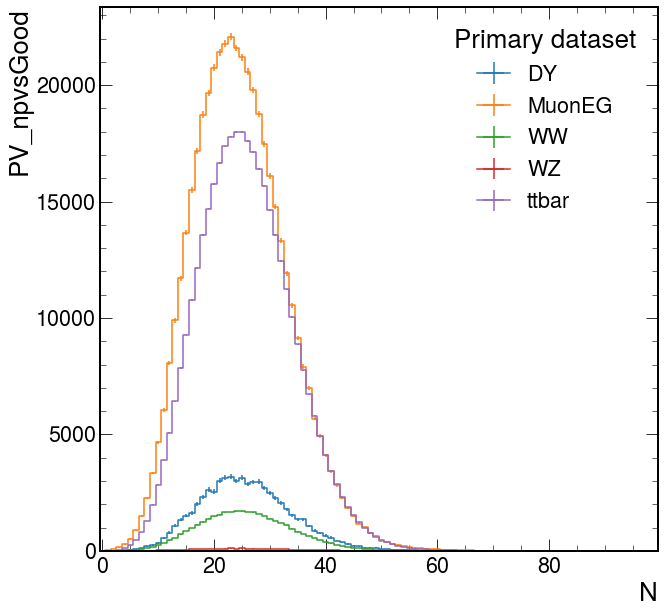

In [106]:
histogram = output['PV_npvsGood']
ax = hist.plot1d(histogram,overlay="dataset", stack=False)

Data: 462689.0 MC: 480303.36


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: divide by zero encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: divide by zero encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:39: RuntimeWarning: invalid value encounter

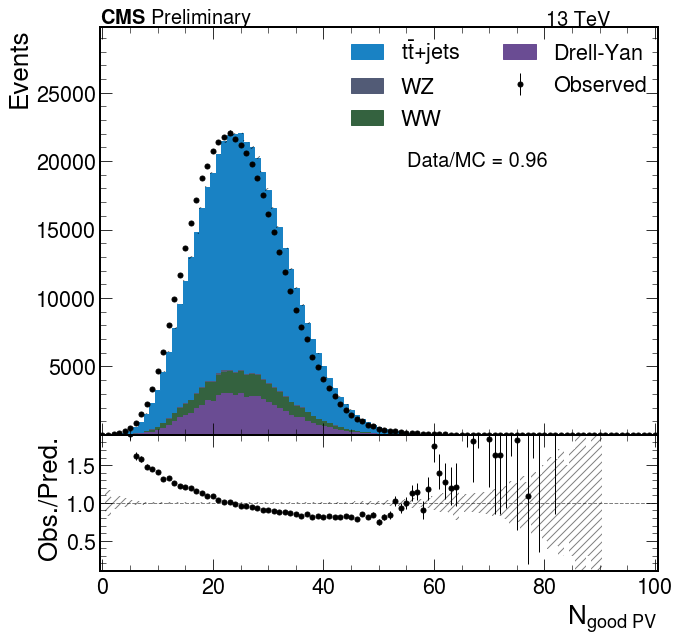

In [118]:
makePlot(output['PV_npvsGood'], 'multiplicity', bins=None, log=False, normalize=True, axis_label=r'$N_{good\ PV}$')

Data: 462689.0 MC: 480303.36


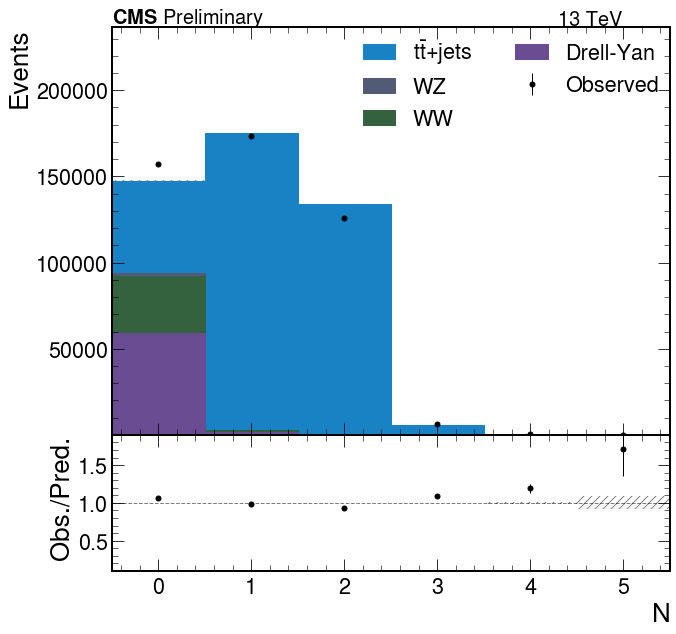

In [108]:
makePlot(output['N_b'], 'multiplicity', bins=N_bins_red, log=False, normalize=True,)

Data: 462689.0 MC: 480303.36


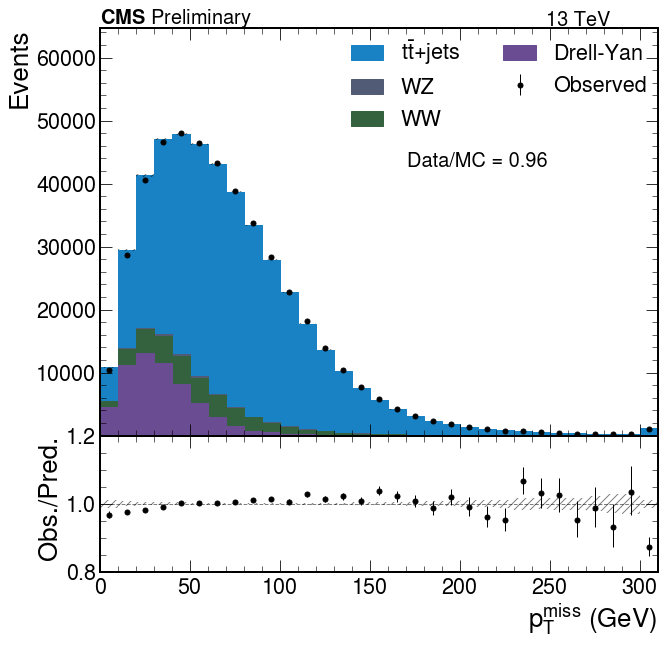

In [125]:
makePlot(
    output['MET'], 'pt', bins=pt_bins,
    log=False, normalize=True,
    axis_label=r'$p_T^{miss}\ (GeV)$',
    ratio_range=(0.8,1.2)
)

Data: 502351.0 MC: 568478.81


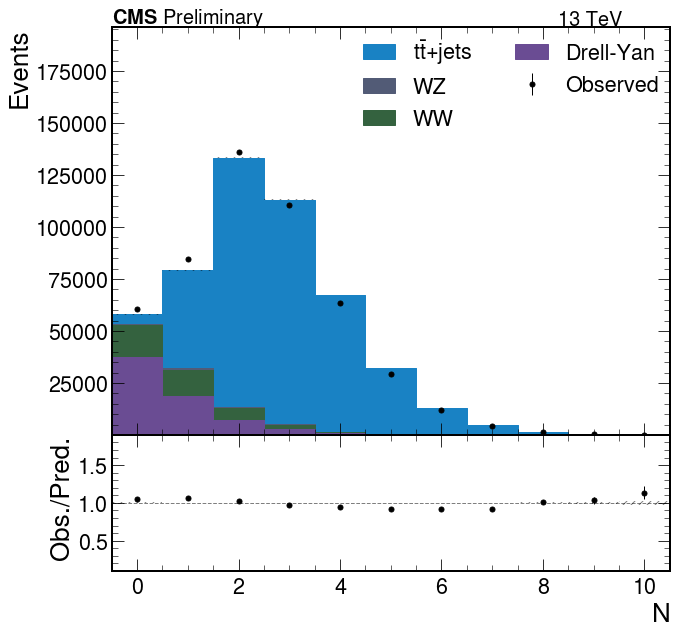

In [212]:
makePlot(output['N_jet'], 'multiplicity', bins=N_bins, log=False, normalize=True,)

Data: 462689.0 MC: 480303.36


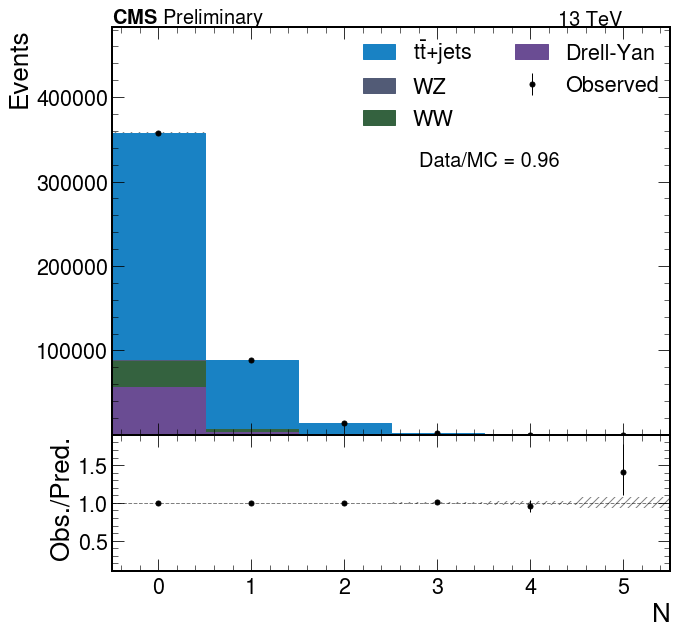

In [126]:
makePlot(output['N_fwd'], 'multiplicity', bins=N_bins_red, log=False, normalize=True,)

Data: 24347.0 MC: 27078.06


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:173: RuntimeWarning: invalid value encountered in true_divide
  
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:174: RuntimeWarning: invalid value encountered in true_divide
  ax.fill_between(x=bins, y1=np.r_[down, down[-1]], y2=np.r_[up, up[-1]], **opts)


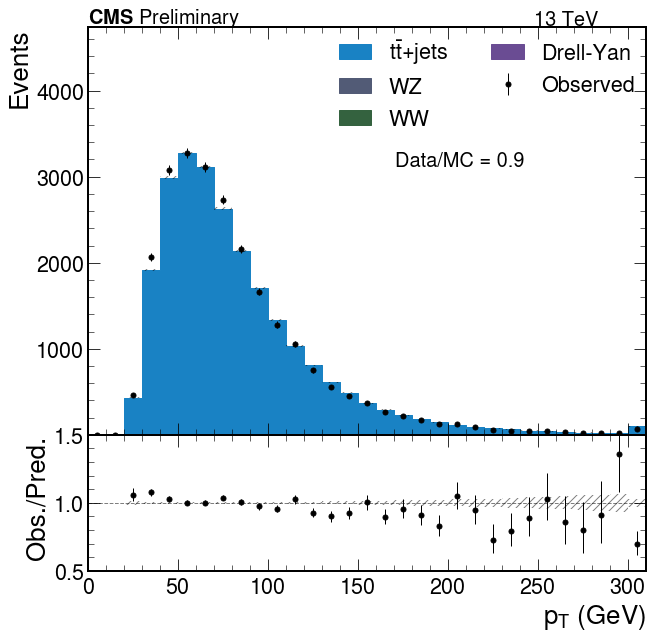

In [128]:
makePlot(output['lead_lep'], 'pt', bins=pt_bins, log=False, normalize=True, ratio_range=(0.5,1.5))

Data: 26242.0 MC: 34977.04


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:165: RuntimeWarning: invalid value encountered in true_divide
  if ratio:
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:166: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central


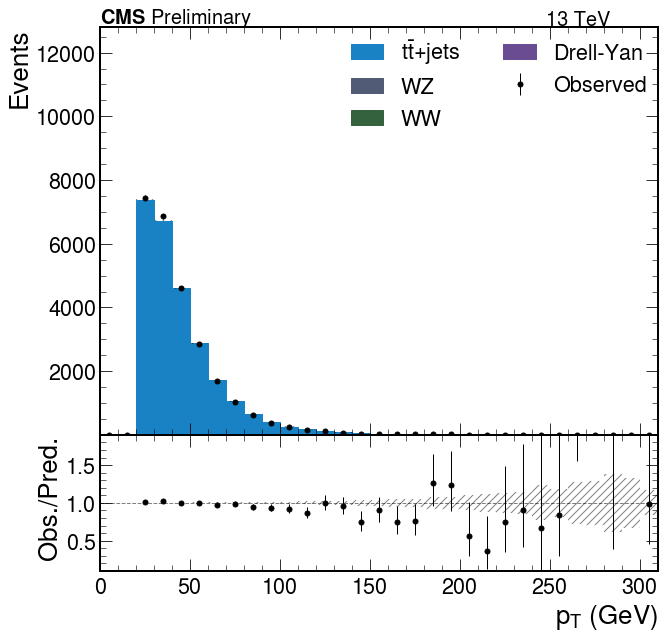

In [215]:
makePlot(output['trail_lep'], 'pt', bins=pt_bins, log=False, normalize=True,)

Data: 26242.0 MC: 34977.04


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:165: RuntimeWarning: invalid value encountered in true_divide
  if ratio:
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:166: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central
'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Figure saved in: /home/users/dspitzba/public_html/tW_scattering/dump/fwd_jet_pt.pdf


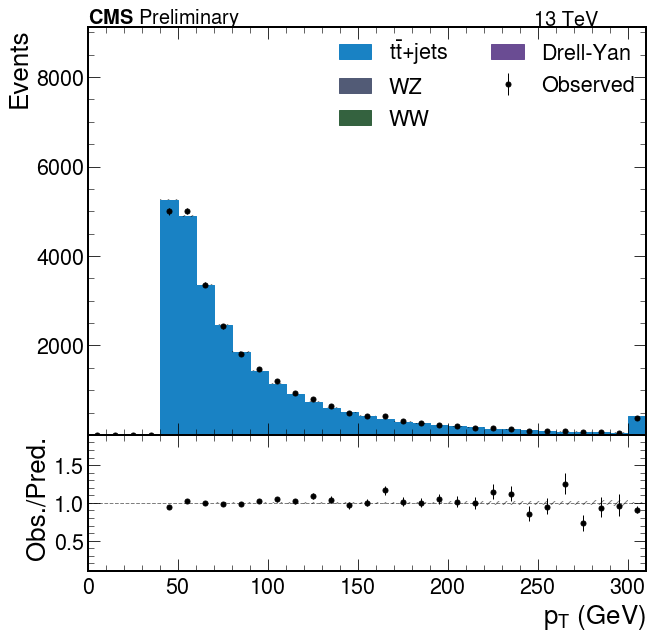

In [216]:
makePlot(output['fwd_jet'], 'pt', pt_bins, log=False, normalize=True, 
         save='/home/users/dspitzba/public_html/tW_scattering/dump/fwd_jet_pt.pdf'
        )

Data: 26242.0 MC: 34977.04


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:165: RuntimeWarning: invalid value encountered in true_divide
  if ratio:
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:166: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central


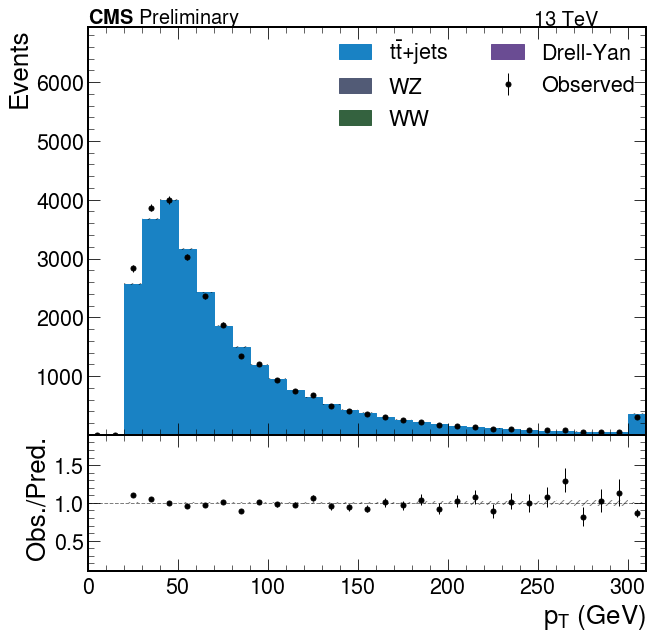

In [217]:
makePlot(output['b1'], 'pt', bins=pt_bins, log=False, normalize=True,)

Data: 26242.0 MC: 34977.04


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:165: RuntimeWarning: invalid value encountered in true_divide
  if ratio:
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:166: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central


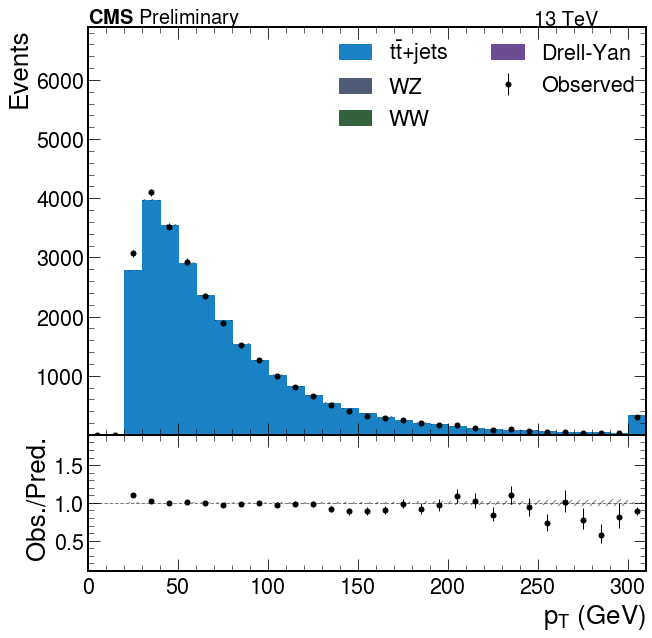

In [218]:
makePlot(output['b2'], 'pt', bins=pt_bins, log=False, normalize=True,)


Data: 26242.0 MC: 34977.04


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:165: RuntimeWarning: invalid value encountered in true_divide
  if ratio:
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:166: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central


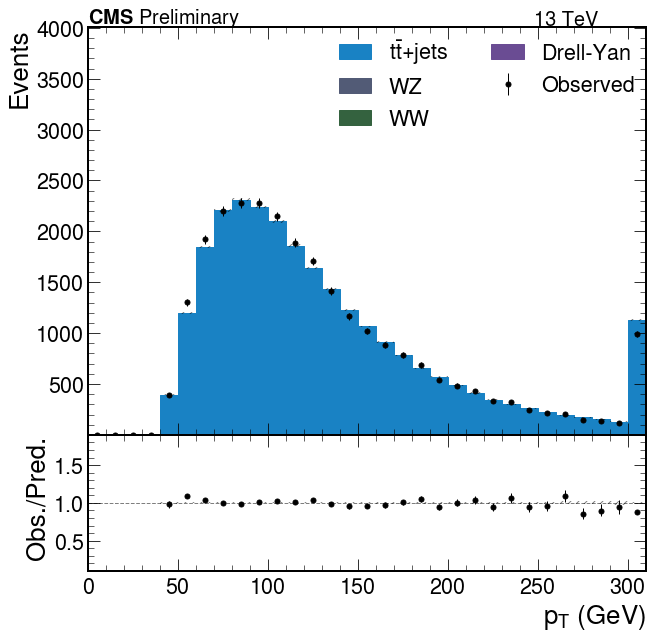

In [219]:
makePlot(output['j1'], 'pt', bins=pt_bins, log=False, normalize=True,)

Data: 26242.0 MC: 34977.04


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:165: RuntimeWarning: invalid value encountered in true_divide
  if ratio:
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:166: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central


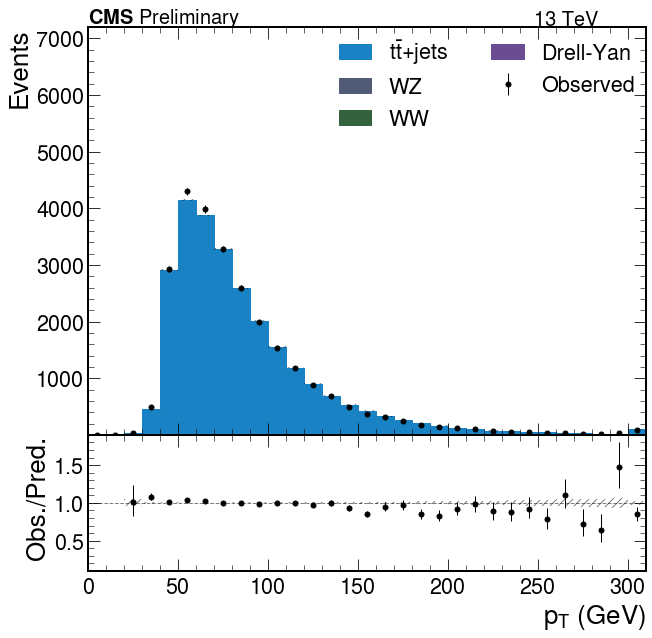

In [220]:
makePlot(output['j2'], 'pt', bins=pt_bins, log=False, normalize=True,)

Data: 26242.0 MC: 34977.04


/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:357: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/miniconda3/envs/coffeadev/lib/python3.8/site-packages/coffea/hist/plot.py:364: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = numpy.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:165: RuntimeWarning: invalid value encountered in true_divide
  if ratio:
/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:166: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central


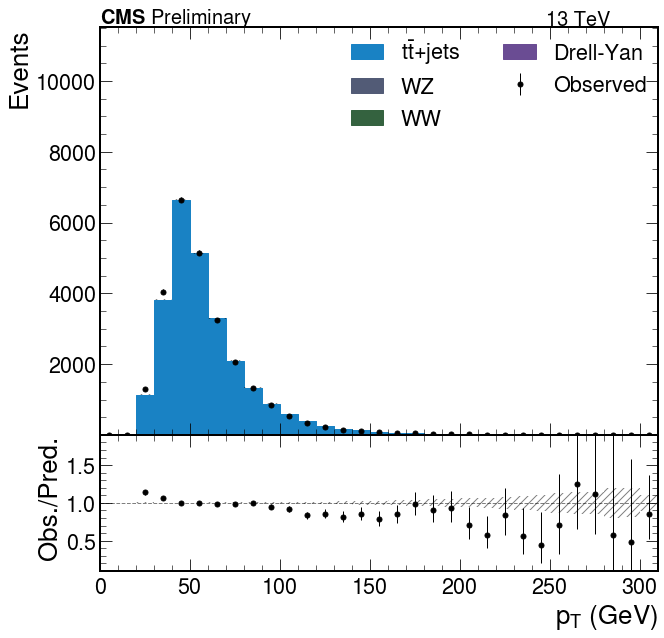

In [221]:
makePlot(output['j3'], 'pt', bins=pt_bins, log=False, normalize=True,)

It seems like either we have a wrong normalization of ttbar, missing data events, or the lepton SFs are huge (and the PU reweighting also contributes much).

With ttH lepton IDs this is the normalization:

Data: 20146.0 MC: 28085.86

Looser SS ID:

Data: 26242.0 MC: 34977.04

There's some missing 0b simulation, potentially W+jets with a fake?

Let's implement the proper lepton SFs and then see, SFs around 0.9 will already bring data/MC to agreement.

# Some development stuff

In [42]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

# the below command will change to .from_root in coffea v0.7.0
events = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/tW_scattering/tW_scattering/nanoAOD/tW_scattering_nanoAOD_123.root', schemaclass=NanoAODSchema).events()

In [201]:
weight = Weights(len(events))
#weight.weight()

In [11]:
import uproot4
fin = uproot4.open('/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.2/tW_scattering_nanoAOD/nanoSkim_1.root')

In [12]:
fin['Events'].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nElectron            | uint32_t                 | AsDtype('>u4')
Electron_deltaEtaSC  | float[]                  | AsJagged(AsDtype('>f4'))
Electron_dxy         | float[]                  | AsJagged(AsDtype('>f4'))
Electron_dz          | float[]                  | AsJagged(AsDtype('>f4'))
Electron_eCorr       | float[]                  | AsJagged(AsDtype('>f4'))
Electron_eInvMinu... | float[]                  | AsJagged(AsDtype('>f4'))
Electron_energyErr   | float[]                  | AsJagged(AsDtype('>f4'))
Electron_eta         | float[]                  | AsJagged(AsDtype('>f4'))
Electron_hoe         | float[]                  | AsJ

In [13]:
from coffea.btag_tools import BTagScaleFactor

In [14]:
btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/Tools/data/btag/DeepJet_102XSF_V2.csv"), "medium")

print("SF:", btag_sf.eval("central", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))
print("systematic +:", btag_sf.eval("up", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt))

SF: [[1.29, 1.33, 0.961, 0.966, 1.47, 1.52, ... 1.52, 1.52, 0.994, 1.52, 1.52, 1.52]]
systematic +: [[1.53, 1.58, 0.973, 0.978, 1.71, 1.75, ... 1.75, 1.74, 1.19, 1.74, 1.74, 1.74]]


In [15]:
sf = btag_sf.eval("central", events.Jet.hadronFlavour, abs(events.Jet.eta), events.Jet.pt, )
len(sf)

1000

In [20]:
        ev = events
        ## Muons
        muon     = Collections(ev, "Muon", "tightTTH").get()
        vetomuon = Collections(ev, "Muon", "vetoTTH").get()
        dimuon   = choose(muon, 2)
        SSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)>0, axis=1)
        OSmuon   = ak.any((dimuon['0'].charge * dimuon['1'].charge)<0, axis=1)
        leading_muon_idx = ak.singletons(ak.argmax(muon.pt, axis=1))
        leading_muon = muon[leading_muon_idx]
        
        ## Electrons
        electron     = Collections(ev, "Electron", "tightTTH").get()
        vetoelectron = Collections(ev, "Electron", "vetoTTH").get()
        dielectron   = choose(electron, 2)
        SSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)>0, axis=1)
        OSelectron   = ak.any((dielectron['0'].charge * dielectron['1'].charge)<0, axis=1)
        leading_electron_idx = ak.singletons(ak.argmax(electron.pt, axis=1))
        leading_electron = electron[leading_electron_idx]
        
        ## Merge electrons and muons - this should work better now in ak1
        lepton   = ak.concatenate([muon, electron], axis=1)
        dilepton = cross(muon, electron)
        SSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)>0, axis=1)
        OSlepton = ak.any((dilepton['0'].charge * dilepton['1'].charge)<0, axis=1)
        leading_lepton_idx = ak.singletons(ak.argmax(lepton.pt, axis=1))
        leading_lepton = lepton[leading_lepton_idx]
        trailing_lepton_idx = ak.singletons(ak.argmin(lepton.pt, axis=1))
        trailing_lepton = lepton[trailing_lepton_idx]

In [38]:
selection = ((ak.num(electron) + ak.num(muon))==2)

ak.to_numpy(ak.flatten(leading_lepton[selection].pt))

array([127.076775,  96.17632 , 103.22386 ,  38.435608,  33.92872 ,
        61.140045,  90.60478 ,  39.29859 , 108.46329 ,  79.80157 ,
       126.51279 ,  77.26335 , 192.73763 , 148.70555 ,  55.059555,
       137.83707 ,  37.19563 ,  60.521458,  56.741486, 105.11551 ,
        73.54765 ,  44.736988, 225.69763 , 144.86429 ,  82.8668  ,
        44.80729 ,  66.56819 ,  94.25571 ,  68.82681 ,  34.128735,
        68.311554,  83.521675,  72.75266 , 167.71571 , 106.35246 ,
        80.22213 , 238.52428 ,  75.913376, 119.99922 ,  98.25242 ,
        59.49584 , 184.49687 , 129.19702 ,  49.341827,  41.503616,
       124.128746, 167.67902 ], dtype=float32)

In [87]:
electron = Collections(events, "Electron", "tight", verbose=True).get()
#muon = Collections(events, "Muon", "tight").get()

## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0

 - tight electron MVA ID
 - custom multi isolation
 - trigger safe


In [62]:
electron.etaSC

<Array [[], [-0.139], ... 0.214, 0.453], []] type='1000 * var * float32'>

In [64]:
test = events.Electron

In [51]:
setattr(muon, "ptErrRel", True)

In [52]:
muon.ptErrRel

True

In [53]:
muon.ptErrRel2 = False

In [54]:
muon.ptErrRel2

False

In [77]:
electron.sieie

<Array [[], [0.0116], ... 0.0125, 0.0217], []] type='1000 * var * float32[parame...'>